# Uncertainty Quantification using Image Matching - Cylinder wake


## Description

Based on paper and source code:
 - Sciacchitano, A., Wieneke, B., & Scarano, F. (2013). PIV uncertainty quantification by image matching. *Measurement Science and Technology*, 24 (4). https://doi.org/10.1088/0957-0233/24/4/045302. 
 - http://piv.de/uncertainty/?page_id=221
 
*Step 1: Particle peak detection*

As described by (Sciacchitano et al., 2013, Eq. 1), the image intensity product $\Pi$ from image matching intensities is defined as:
$$
\Pi = \hat{I}_1\hat{I}_2
$$
The peaks image $\varphi$ is defined as:
$$
\varphi(i,j) = \begin{cases}
1\quad\text{if }\Pi(i,j)\text{ is a relative maximum} \\
0\quad\text{otherwise}
\end{cases}
$$

*Step 2: Disparity vector computation*

The sub-pixel peak position estimator adopted here is the standard 3-point Gaussian fit. The particle positions of times $t_1$ and $t_2$ are 
defined as $\boldsymbol{X}^1 = \{x^1_1,x^1_2,...,x^1_N\}$ and $\boldsymbol{X}^2 = \{x^2_1,x^2_2,...,x^2_N\}$. Discrete disparity vectors are defined as:
$$
\boldsymbol{D} = \boldsymbol{X}^2 - \boldsymbol{X}^1
$$


## Setup

**Packages**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

**Load images**

In [3]:
parent_path = "./data/particledisparity_code_testdata/"
image_pair = np.array(
    [
        plt.imread(os.path.join(parent_path + ipath)).astype("float")
        for ipath in ["B00010.tif", "B00011.tif"]
    ]
)

**Load reference velocity**

In [4]:
data = np.loadtxt(os.path.join(parent_path + "B00010_UQ.dat"), skiprows=3).T

I, J = 128, 128
X_ref = np.reshape(data[0], (I, J)) - 1  # zero-index
Y_ref = np.reshape(data[1], (I, J)) - 1
U_ref = np.stack((np.reshape(data[2], (I, J)), np.reshape(data[3], (I, J))))
e_ref = np.stack((np.reshape(data[4], (I, J)), np.reshape(data[5], (I, J))))
N_ref = np.reshape(data[6], (I, J))

## Uncertainity quantificiation using image matching

In [11]:
%%time
X, Y, delta, N, mu, sigma = pivuq.disparity.sws(
    image_pair,
    U_ref,
    window_size=16,
    window="gaussian",
    radius=1,
    sliding_window_subtraction=True,
    ROI=[10, 450, 220, 430],
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=5,
    warp_nsteps=1,
)

CPU times: user 5.28 s, sys: 3.35 ms, total: 5.29 s
Wall time: 548 ms


## Plot: Disparity statistics

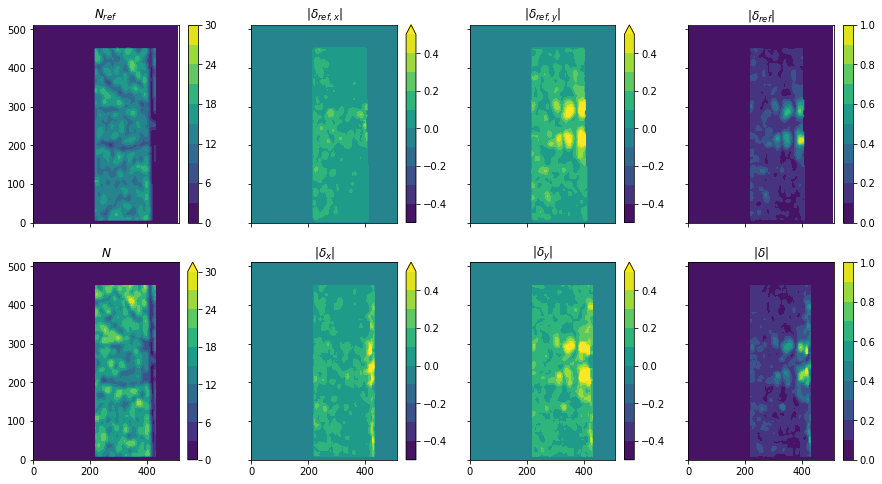

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15, 8))

# References
ax = axes[0, 0]
im = ax.contourf(X_ref, Y_ref, N_ref, np.linspace(0, 30, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$N_{ref}$")

ax = axes[0, 1]
im = ax.contourf(X_ref, Y_ref, e_ref[0], np.linspace(-0.5, 0.5, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{ref,x}|$")

ax = axes[0, 2]
im = ax.contourf(X_ref, Y_ref, e_ref[1], np.linspace(-0.5, 0.5, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{ref,y}|$")

ax = axes[0, 3]
im = ax.contourf(X_ref, Y_ref, np.linalg.norm(e_ref, axis=0), np.linspace(0, 1, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{ref}|$")


# Calculated
ax = axes[1, 0]
im = ax.contourf(X, Y, N, np.linspace(0, 30, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$N$")

ax = axes[1, 1]
im = ax.contourf(X, Y, delta[0], np.linspace(-0.5, 0.5, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{x}|$")

ax = axes[1, 2]
im = ax.contourf(X, Y, delta[1], np.linspace(-0.5, 0.5, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta_{y}|$")

ax = axes[1, 3]
im = ax.contourf(X, Y, np.linalg.norm(delta, axis=0), np.linspace(0, 1, 11))
fig.colorbar(im, ax=ax)
ax.set(title="$|\delta|$");

## Plot: Disparity histogram

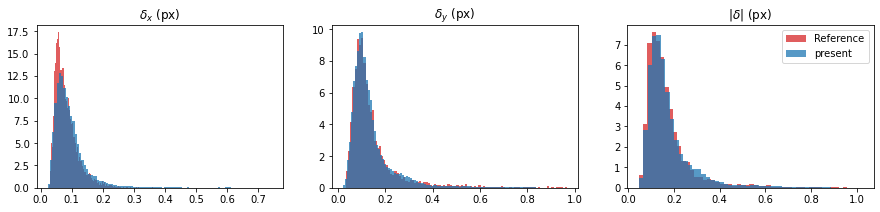

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3))

for i, (ax, label) in enumerate(
    zip(axes[:2], [r"$\delta_x$ (px)", r"$\delta_y$ (px)"])
):
    values = e_ref[i].ravel()
    ax.hist(
        values[np.abs(values) > 0],
        bins=100,
        density=True,
        color="tab:red",
        label="Reference",
        alpha=0.75,
    )
    ax.set(title=label)

for i, (ax, label) in enumerate(
    zip(axes[:2], [r"$\delta_x$ (px)", r"$\delta_y$ (px)"])
):
    values = delta[i].ravel()
    ax.hist(
        values[np.abs(values) > 0],
        bins=100,
        density=True,
        color="tab:blue",
        label="present",
        alpha=0.75,
    )
    ax.set(title=label)

ax = axes[-1]
values = np.linalg.norm(e_ref, axis=0).ravel()
ax.hist(
    values[np.abs(values) > 0],
    bins=50,
    density=True,
    color="tab:red",
    label="Reference",
    alpha=0.75,
)

values = np.linalg.norm(delta, axis=0).ravel()
ax.hist(
    values[np.abs(values) > 0],
    bins=50,
    density=True,
    color="tab:blue",
    label="present",
    alpha=0.75,
)
ax.set(title="$|\delta|$ (px)")
ax.legend();